In [1]:
%matplotlib inline

In [1]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
import scipy.integrate
import scipy.interpolate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
import os
import multiprocessing
import json
# For parallelization
from joblib import Parallel, delayed

import lmfit
import nekhoroshev_tools as nt

from working_experiment_script.working_experiment_functions import *

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [6]:
FIGPATH = "ext_fig/"

In [7]:
FIGPATH

'fig/'

In [16]:
FIGPATH = "../PAPER_DIFFUSION/figs/"


In [4]:
with open("working_experiment_script/full_dict.pkl", 'rb') as f:
    full_dict = pickle.load(f)

In [5]:
print("Before deletion: ", full_dict.keys())
to_delete = []
for i in full_dict:
    if len(full_dict[i]) < 3:
        to_delete.append(i)
for i in to_delete:    
    del full_dict[i]
print("After deletion: ", full_dict.keys())

Before deletion:  dict_keys([28.000000000000004, 10.0, 10.000000000000002, 12.000000000000002, 14.0, 14.000000000000004, 16.0, 16.000000000000007, 18.000000000000004, 20.0, 20.000000000000004, 22.0, 22.000000000000007, 24.0, 24.000000000000007, 26.0, 26.000000000000007, 28.000000000000007, 30.0, 4.0, 6.000000000000001, 8.0, 8.000000000000002])
After deletion:  dict_keys([28.000000000000004, 10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004, 20.0, 22.0, 24.0, 26.0, 30.0, 4.0, 6.000000000000001, 8.0])


In [11]:
print("I_max positions: ", full_dict.keys())
print("barrier steps: ", full_dict[10.0].keys())
print("fraction considered: ", full_dict[10.0][1.0].keys())
print("Data filters available: ", full_dict[10.0][1.0][0.5].keys())
print("Fit kinds: ", full_dict[10.0][1.0][0.5][np.inf, 0.5].keys())
print("Accessing data: ")
full_dict[10.0][1.0][0.5][np.inf, 0.5]["all"].params


I_max positions:  dict_keys([10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004, 20.0, 22.0, 24.0, 26.0, 28.000000000000004, 30.0, 4.0, 6.000000000000001, 8.0])
barrier steps:  dict_keys([0.02, 0.1, 0.2, 1.0])
fraction considered:  dict_keys([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0])
Data filters available:  dict_keys(['info', (1.0, 0.001), (1.0, 0.01), (1.0, 0.1), (1.0, 0.5), (inf, 0.001), (inf, 0.01), (inf, 0.1), (inf, 0.5)])
Fit kinds:  dict_keys(['all', 'backward_only', 'forward_only'])
Accessing data: 


name,value,standard error,relative error,initial value,min,max,vary
I_star,19.1939026,0.13173402,(0.69%),20.0,0.10000000,inf,True
k,0.34868529,0.00565947,(1.62%),0.33,0.00000000,inf,True
c,330.998299,0.00000000,(0.00%),330.99829890330193,-inf,inf,False


In [12]:
print(full_dict[10.0][1.0][0.5][np.inf, 0.5]["all"].params["k"].value)
print(full_dict[10.0][1.0][0.5][np.inf, 0.5]["all"].params["I_star"].value)

0.3486852938672311
19.193902612135002


In [14]:
figsize = (7, 4)
figsize_compressed = (7, 3)
figsize_compressed_half = (7, 3.5)
figsize_large = (7, 5)

# Plotting all fit results

## Different relaxation times

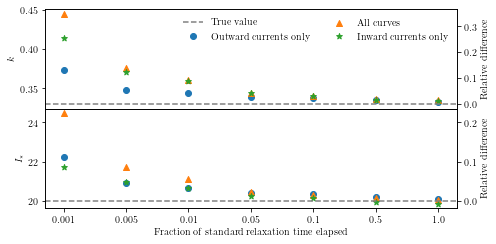

In [22]:
I_max = 8.0
b_step = 0.1
fraction = 0.5
f = (np.inf, 0.5)
f_bis = (1.0, 0.5)
fit_kind = "forward_only"

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize_compressed_half)

ax_bis = ax.twinx()
ax2_bis = ax2.twinx()

data_x = []
data_k = []
data_I = []
data_x_all = []
data_k_all = []
data_I_all = []
data_x_back = []
data_k_back = []
data_I_back = []

tmp = full_dict[I_max][b_step]
for i in tmp:
    if fit_kind in tmp[i][f]:
        # print(i)
        data_x.append(i)
        data_x_all.append(i)
        data_x_back.append(i)
        data_k.append(tmp[i][f][fit_kind].params["k"].value)
        data_I.append(tmp[i][f][fit_kind].params["I_star"].value)
        if "all" in tmp[i][f_bis]:
            data_k_all.append(tmp[i][f_bis]["all"].params["k"].value)
            data_I_all.append(tmp[i][f_bis]["all"].params["I_star"].value)
        else:
            data_k_all.append(np.nan)
            data_I_all.append(np.nan)
        if "backward_only" in tmp[i][f_bis]:
            data_k_back.append(tmp[i][f_bis]["backward_only"].params["k"].value)
            data_I_back.append(tmp[i][f_bis]["backward_only"].params["I_star"].value)
        else:
            data_k_back.append(np.nan)
            data_I_back.append(np.nan)

data_k = [x for _, x in sorted(zip(data_x, data_k))]
data_I = [x for _, x in sorted(zip(data_x, data_I))]
data_x = sorted(data_x)

data_k_all = [x for _, x in sorted(zip(data_x_all, data_k_all))]
data_I_all = [x for _, x in sorted(zip(data_x_all, data_I_all))]
data_x_all = sorted(data_x_all)

data_k_back = [x for _, x in sorted(zip(data_x_back, data_k_back))]
data_I_back = [x for _, x in sorted(zip(data_x_back, data_I_back))]
data_x_back = sorted(data_x_back)

ax.axhline(0.33, c="grey", label="True value", linestyle="dashed")
ax.scatter(np.arange(len(data_k)), data_k, label="Outward currents only")
ax.scatter(np.arange(len(data_k_all)), data_k_all, marker="^", label="All curves")
ax.scatter(np.arange(len(data_k_back)), data_k_back, marker="*", label="Inward currents only")

ax.legend(ncol=2, frameon=False)

mn, mx = ax.get_ylim()
ax_bis.set_ylim(mn/0.33 - 1, mx/0.33 - 1)

ax2.axhline(20.0, c="grey", linestyle="dashed")
ax2.scatter(np.arange(len(data_I)), data_I)
ax2.scatter(np.arange(len(data_I_all)), data_I_all, marker="^")
ax2.scatter(np.arange(len(data_I_back)), data_I_back, marker="*")

mn, mx = ax2.get_ylim()
ax2_bis.set_ylim(mn/20.0 - 1, mx/20.0 - 1)

ax.set_xticks(np.arange(len(data_k)))
ax.set_xticklabels(data_x)

ax2.set_xlabel("Fraction of standard relaxation time elapsed")
ax.set_ylabel("$k$")
ax2.set_ylabel("$I_\\ast$")
ax_bis.set_ylabel("Relative difference")
ax2_bis.set_ylabel("Relative difference")

#ax.set_title("Fit performance for different elapsed relaxation times")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax.get_xticklabels(), visible=False)

plt.savefig(os.path.join(FIGPATH, "all_different_time.pdf"), dpi=600, pad_inches=0.0)


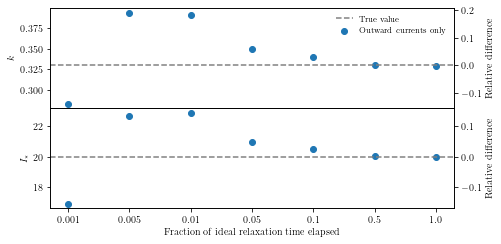

In [34]:
I_max = 8.0
b_step = 0.1
fraction = 0.5
f = (np.inf, 0.1)
f_bis = (1.0, 0.5)
fit_kind = "forward_only"

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize_compressed_half)

ax_bis = ax.twinx()
ax2_bis = ax2.twinx()

data_x = []
data_k = []
data_I = []
data_x_all = []
data_k_all = []
data_I_all = []
data_x_back = []
data_k_back = []
data_I_back = []

tmp = full_dict[I_max][b_step]
for i in tmp:
    if fit_kind in tmp[i][f]:
        # print(i)
        data_x.append(i)
        data_x_all.append(i)
        data_x_back.append(i)
        data_k.append(tmp[i][f][fit_kind].params["k"].value)
        data_I.append(tmp[i][f][fit_kind].params["I_star"].value)
        if "all" in tmp[i][f_bis]:
            data_k_all.append(tmp[i][f_bis]["all"].params["k"].value)
            data_I_all.append(tmp[i][f_bis]["all"].params["I_star"].value)
        else:
            data_k_all.append(np.nan)
            data_I_all.append(np.nan)
        if "backward_only" in tmp[i][f_bis]:
            data_k_back.append(tmp[i][f_bis]["backward_only"].params["k"].value)
            data_I_back.append(tmp[i][f_bis]["backward_only"].params["I_star"].value)
        else:
            data_k_back.append(np.nan)
            data_I_back.append(np.nan)

data_k = [x for _, x in sorted(zip(data_x, data_k))]
data_I = [x for _, x in sorted(zip(data_x, data_I))]
data_x = sorted(data_x)

data_k_all = [x for _, x in sorted(zip(data_x_all, data_k_all))]
data_I_all = [x for _, x in sorted(zip(data_x_all, data_I_all))]
data_x_all = sorted(data_x_all)

data_k_back = [x for _, x in sorted(zip(data_x_back, data_k_back))]
data_I_back = [x for _, x in sorted(zip(data_x_back, data_I_back))]
data_x_back = sorted(data_x_back)

ax.axhline(0.33, c="grey", label="True value", linestyle="--")
ax.scatter(np.arange(len(data_k)), data_k, label="Outward currents only")
# ax.scatter(np.arange(len(data_k_all)), data_k_all, marker="x", label="All curves")
# ax.scatter(np.arange(len(data_k_back)), data_k_back, marker="*", label="Inward currents only")

ax.legend(frameon=False, fontsize="small")

mn, mx = ax.get_ylim()
ax_bis.set_ylim(mn/0.33 - 1, mx/0.33 - 1)

ax2.axhline(20.0, c="grey", linestyle="--")
ax2.scatter(np.arange(len(data_I)), data_I)
# ax2.scatter(np.arange(len(data_I_all)), data_I_all, marker="x")
# ax2.scatter(np.arange(len(data_I_back)), data_I_back, marker="*")

mn, mx = ax2.get_ylim()
ax2_bis.set_ylim(mn/20.0 - 1, mx/20.0 - 1)

ax.set_xticks(np.arange(len(data_k)))
ax.set_xticklabels(data_x)

ax2.set_xlabel("Fraction of ideal relaxation time elapsed")
ax.set_ylabel("$k$")
ax2.set_ylabel("$I_\\ast$")
ax_bis.set_ylabel("Relative difference")
ax2_bis.set_ylabel("Relative difference")

#ax.set_title("Fit performance for different elapsed relaxation times")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax.get_xticklabels(), visible=False)

plt.savefig(os.path.join(FIGPATH, "different_time.pdf"), dpi=600, pad_inches=0.0)


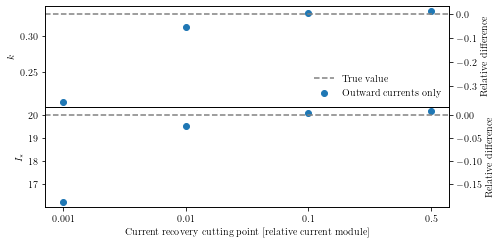

In [30]:
I_max = 10.0
b_step = 0.1
fraction = 0.5
f = (np.inf, 0.5)
fit_kind = "forward_only"

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize_compressed_half)

ax_bis = ax.twinx()
ax2_bis = ax2.twinx()

data_x = []
data_k = []
data_I = []
data_x_all = []
data_k_all = []
data_I_all = []
data_x_back = []
data_k_back = []
data_I_back = []

tmp = full_dict[I_max][b_step][fraction]
for i in tmp:
    if type(i) == int:
        continue
    #print(i, fit_kind in tmp, tmp.keys())
    i_bis = (1.0, i[1])
    if fit_kind in tmp[i]:
        data_x.append(i[1])
        data_k.append(tmp[i][fit_kind].params["k"].value)
        data_I.append(tmp[i][fit_kind].params["I_star"].value)
        if "all" in tmp[i_bis]:
            data_k_all.append(tmp[i_bis]["all"].params["k"].value)
            data_I_all.append(tmp[i_bis]["all"].params["I_star"].value)
        else:
            data_k_all.append(np.nan)
            data_I_all.append(np.nan)
        if "backward_only" in tmp[i_bis]:
            data_k_back.append(tmp[i_bis]["backward_only"].params["k"].value)
            data_I_back.append(
                tmp[i_bis]["backward_only"].params["I_star"].value)
        else:
            data_k_all.append(np.nan)
            data_I_all.append(np.nan)

data_k = [x for _, x in sorted(zip(data_x, data_k))]
data_I = [x for _, x in sorted(zip(data_x, data_I))]
data_x = sorted(data_x)

ax.axhline(0.33, c="grey", label="True value", linestyle="--")
ax.scatter(np.arange(len(data_k)), data_k, label="Outward currents only")
# ax.scatter(np.arange(len(data_k_all)), data_k_all, marker="x", label="All curves")
# ax.scatter(np.arange(len(data_k_back)), data_k_back, marker="*", label="Inward currents only")

ax.legend(frameon=False, loc="lower right")

mn, mx = ax.get_ylim()
ax_bis.set_ylim(mn/0.33 - 1, mx/0.33 - 1)

ax2.axhline(20.0, c="grey", linestyle="--")
ax2.scatter(np.arange(len(data_I)), data_I)
# ax2.scatter(np.arange(len(data_I_all)), data_I_all, marker="x")
# ax2.scatter(np.arange(len(data_I_back)), data_I_back, marker="*")

mn, mx = ax2.get_ylim()
ax2_bis.set_ylim(mn/20.0 - 1, mx/20.0 - 1)

ax.set_xticks(np.arange(len(data_k)))
ax.set_xticklabels(data_x)

ax2.set_xlabel("Current recovery cutting point [relative current module]")
ax.set_ylabel("$k$")
ax2.set_ylabel("$I_\\ast$")
ax_bis.set_ylabel("Relative difference")
ax2_bis.set_ylabel("Relative difference")

#ax.set_title("Fit performance for different recovery cutting points")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax.get_xticklabels(), visible=False)

plt.savefig(os.path.join(FIGPATH, "different_cut.pdf"), dpi=600, pad_inches=0.0)


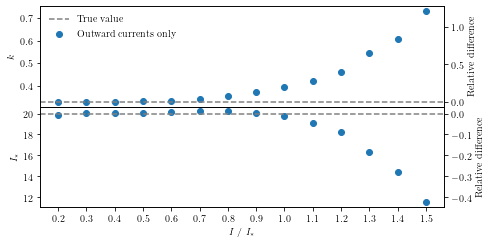

In [35]:
I_max = 8.0
b_step = 0.1
fraction = 0.5
f = (np.inf, 0.1)
f_bis = (1.0, 0.1)
fit_kind = "forward_only"

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize_compressed_half)

ax_bis = ax.twinx()
ax2_bis = ax2.twinx()

data_x = []
data_k = []
data_I = []
data_x_all = []
data_k_all = []
data_I_all = []
data_x_back = []
data_k_back = []
data_I_back = []

tmp = full_dict
for i in tmp:
    #print(i)
    if b_step in tmp[i]:
        if fraction in tmp[i][b_step]:
            if f in tmp[i][b_step][fraction]:
                if fit_kind in tmp[i][b_step][fraction][f]:
                    #print("^^^in^^^")
                    data_x.append(i)
                    data_k.append(tmp[i][b_step][fraction][f]
                                  [fit_kind].params["k"].value)
                    data_I.append(tmp[i][b_step][fraction][f]
                                  [fit_kind].params["I_star"].value)

                    # print(i, tmp[i][b_step][fraction][f_bis])
                    if "all" in tmp[i][b_step][fraction][f_bis]:
                        if tmp[i][b_step][fraction][f_bis]["all"] == "FAILED!":
                            data_k_all.append(np.nan)
                            data_I_all.append(np.nan)
                        else:
                            data_k_all.append(tmp[i][b_step][fraction][f_bis]
                                              ["all"].params["k"].value)
                            data_I_all.append(tmp[i][b_step][fraction][f_bis]
                                              ["all"].params["I_star"].value)
                    else:
                        data_k_all.append(np.nan)
                        data_I_all.append(np.nan)

                    if "backward_only" in tmp[i][b_step][fraction][f_bis]:
                        if tmp[i][b_step][fraction][f_bis]["backward_only"] == "FAILED!":
                            data_k_back.append(np.nan)
                            data_I_back.append(np.nan)
                        else:
                            data_k_back.append(tmp[i][b_step][fraction][f_bis]
                                               ["backward_only"].params["k"].value)
                            data_I_back.append(tmp[i][b_step][fraction][f_bis]
                                               ["backward_only"].params["I_star"].value)
                    else:
                        data_k_back.append(np.nan)
                        data_I_back.append(np.nan)

data_k = [x for _, x in sorted(zip(data_x, data_k))]
data_I = [x for _, x in sorted(zip(data_x, data_I))]
data_k_all = [x for _, x in sorted(zip(data_x, data_k_all))]
data_I_all = [x for _, x in sorted(zip(data_x, data_I_all))]
data_k_back = [x for _, x in sorted(zip(data_x, data_k_back))]
data_I_back = [x for _, x in sorted(zip(data_x, data_I_back))]
data_x = sorted(data_x)

ax.axhline(0.33, c="grey", label="True value", linestyle="--")
ax.scatter(np.arange(len(data_k)), data_k, label="Outward currents only")
# ax.scatter(np.arange(len(data_k_all)), data_k_all, marker="x", label="All curves")
# ax.scatter(np.arange(len(data_k_back)), data_k_back, marker="*", label="Inward currents only")

ax.legend(frameon=False)

mn, mx = ax.get_ylim()
ax_bis.set_ylim(mn/0.33 - 1, mx/0.33 - 1)

ax2.axhline(20.0, c="grey", linestyle="--")
ax2.scatter(np.arange(len(data_I)), data_I)
# ax2.scatter(np.arange(len(data_I_all)), data_I_all, marker="x")
# ax2.scatter(np.arange(len(data_I_back)), data_I_back, marker="*")

mn, mx = ax2.get_ylim()
ax2_bis.set_ylim(mn/20.0 - 1, mx/20.0 - 1)

ax.set_xticks(np.arange(len(data_k)))
ax.set_xticklabels(["{:.1f}".format(x/20) for x in data_x])

ax2.set_xlabel("$I$ $/$ $I_\\ast$")
ax.set_ylabel("$k$")
ax2.set_ylabel("$I_\\ast$")
ax_bis.set_ylabel("Relative difference")
ax2_bis.set_ylabel("Relative difference")

#ax.set_title("Fit performance for different positions of the boundary")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax.get_xticklabels(), visible=False)

plt.savefig(os.path.join(FIGPATH, "different_position.pdf"), dpi=600, pad_inches=0.0)


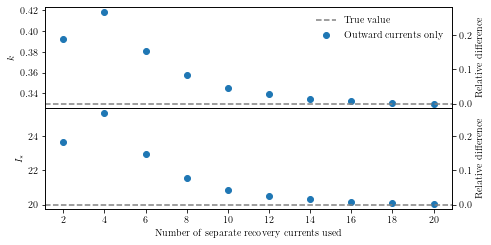

In [36]:
I_max = 8.0
b_step = 0.1
fraction = 0.5
f = (np.inf, 0.1)

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize_compressed_half)

ax_bis = ax.twinx()
ax2_bis = ax2.twinx()

data_x = []
data_k = []
data_I = []

tmp = full_dict[I_max][b_step][fraction]
for i in tmp:
    # print(i)
    if type(i) == int and type(tmp[i][f]["forward_only"]) != str:
        if i%2 == 0:
            data_x.append(i)
            data_k.append(tmp[i][f]["forward_only"].params["k"].value)
            data_I.append(tmp[i][f]["forward_only"].params["I_star"].value)
data_x.append(20)
data_k.append(tmp[f]["forward_only"].params["k"].value)
data_I.append(tmp[f]["forward_only"].params["I_star"].value)

data_k = [x for _, x in sorted(zip(data_x, data_k))]
data_I = [x for _, x in sorted(zip(data_x, data_I))]
data_x = sorted(data_x)

ax.axhline(0.33, c="grey", label="True value", linestyle="--")
ax.scatter(np.arange(len(data_k)), data_k, label="Outward currents only")

ax.legend(frameon=False)

mn, mx = ax.get_ylim()
ax_bis.set_ylim(mn/0.33 - 1, mx/0.33 - 1)

ax2.axhline(20.0, c="grey", linestyle="--")
ax2.scatter(np.arange(len(data_I)), data_I)

mn, mx = ax2.get_ylim()
ax2_bis.set_ylim(mn/20.0 - 1, mx/20.0 - 1)

ax.set_xticks(np.arange(len(data_k)))
ax.set_xticklabels(data_x)

ax2.set_xlabel("Number of separate recovery currents used")
ax.set_ylabel("$k$")
ax2.set_ylabel("$I_\\ast$")
ax_bis.set_ylabel("Relative difference")
ax2_bis.set_ylabel("Relative difference")

#ax.set_title("Fit performance for different number of samples")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax.get_xticklabels(), visible=False)

plt.savefig(os.path.join(FIGPATH, "different_nsamples.pdf"), dpi=600, pad_inches=0.0)


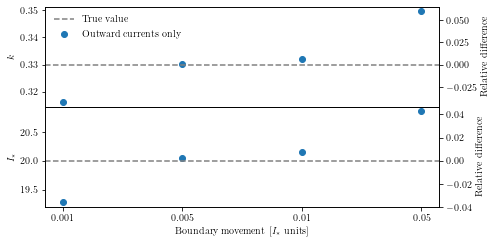

In [38]:
I_max = 8.0
b_step = 0.1
fraction = 0.5
f = (np.inf, 0.1)
f_bis = (np.inf, 0.5)
fit_kind = "forward_only"

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize_compressed_half)

ax_bis = ax.twinx()
ax2_bis = ax2.twinx()

data_x = []
data_k = []
data_I = []
data_x_all = []
data_k_all = []
data_I_all = []
data_x_back = []
data_k_back = []
data_I_back = []

tmp = full_dict[I_max]#[b_step]
for i in tmp:
    if fit_kind in tmp[i][fraction][f]:
        # print(i)
        data_x.append(i / 20.0)
        data_x_all.append(i / 20.0)
        data_x_back.append(i / 20.0)
        data_k.append(tmp[i][fraction][f][fit_kind].params["k"].value)
        data_I.append(tmp[i][fraction][f][fit_kind].params["I_star"].value)
        if "all" in tmp[i][fraction][f_bis] and type(tmp[i][fraction][f_bis]["all"]) != str:
            data_k_all.append(tmp[i][fraction][f_bis]["all"].params["k"].value)
            data_I_all.append(tmp[i][fraction][f_bis]["all"].params["I_star"].value)
        else:
            data_k_all.append(np.nan)
            data_I_all.append(np.nan)
        if "backward_only" in tmp[i][fraction][f_bis] and type(tmp[i][fraction][f_bis]["backward_only"]) != str:
            data_k_back.append(
                tmp[i][fraction][f_bis]["backward_only"].params["k"].value)
            data_I_back.append(
                tmp[i][fraction][f_bis]["backward_only"].params["I_star"].value)
        else:
            data_k_back.append(np.nan)
            data_I_back.append(np.nan)

data_k = [x for _, x in sorted(zip(data_x, data_k))]
data_I = [x for _, x in sorted(zip(data_x, data_I))]
data_x = sorted(data_x)

data_k_all = [x for _, x in sorted(zip(data_x_all, data_k_all))]
data_I_all = [x for _, x in sorted(zip(data_x_all, data_I_all))]
data_x_all = sorted(data_x_all)

data_k_back = [x for _, x in sorted(zip(data_x_back, data_k_back))]
data_I_back = [x for _, x in sorted(zip(data_x_back, data_I_back))]
data_x_back = sorted(data_x_back)

ax.axhline(0.33, c="grey", label="True value", linestyle="--")
ax.scatter(np.arange(len(data_k)), data_k, label="Outward currents only")
# ax.scatter(np.arange(len(data_k_all)), data_k_all, marker="x", label="All curves")
# ax.scatter(np.arange(len(data_k_back)), data_k_back, marker="*", label="Inward currents only")

ax.legend(frameon=False, loc="upper left")

mn, mx = ax.get_ylim()
ax_bis.set_ylim(mn/0.33 - 1, mx/0.33 - 1)

ax2.axhline(20.0, c="grey", linestyle="--")
ax2.scatter(np.arange(len(data_I)), data_I)
# ax2.scatter(np.arange(len(data_I_all)), data_I_all, marker="x")
# ax2.scatter(np.arange(len(data_I_back)), data_I_back, marker="*")

mn, mx = ax2.get_ylim()
ax2_bis.set_ylim(mn/20.0 - 1, mx/20.0 - 1)

ax.set_xticks(np.arange(len(data_k)))
ax.set_xticklabels(data_x)

ax2.set_xlabel("Boundary movement $[I_\\ast$ units$]$")
ax.set_ylabel("$k$")
ax2.set_ylabel("$I_\\ast$")
ax_bis.set_ylabel("Relative difference")
ax2_bis.set_ylabel("Relative difference")

#ax.set_title("Fit performance for different elapsed relaxation times")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax.get_xticklabels(), visible=False)

plt.savefig(os.path.join(FIGPATH, "different_movement_module.pdf"), dpi=600, pad_inches=0.0)
